# Assignment-f10-F24-ann

## Scoring For Precision

In this assignment, our team will build, evaluate, and deploy a model for predicting handwritten digits using the MNIST dataset. 

### Model Exploration

1. Logistic Regression Classifier:
logistic regression presents a solid option for multiclass classification on the MNIST dataset due to its simplicity, interpretability, probabilistic nature, and efficiency. While it may not achieve the highest accuracy compared to more complex models, it serves as a valuable baseline that can provide insights into the data and inform further model development.

2. Random Forests:
Random Forests are ensemble methods that leverage multiple decision trees to improve classification accuracy and robustness. They handle multiclass problems well and are less prone to overfitting, making them ideal for the diverse patterns in handwritten digits.

3. Support Vector Classifier (SVC):
SVC is effective in high-dimensional spaces and can model complex decision boundaries using kernel functions. Its ability to maximize the margin between classes makes it a strong candidate for distinguishing between the various handwritten digits.

4. AdaBoost:
AdaBoost is a powerful gradient boosting framework that excels in handling complex datasets with its efficient implementation and regularization capabilities. Its ability to capture intricate patterns and relationships in the data makes it particularly suited for the MNIST classification task.

5. Multilayer Perceptron:
The Multilayer Perceptron is an excellent candidate for the MNIST multiclass classification task due to its ability to capture complex patterns and relationships in high-dimensional pixel data. By leveraging its capacity for non-linear modeling and automatic feature learning, MLPs can effectively differentiate between the various handwritten digits.


In machine learning, model performance metrics are crucial to understanding how well a model performs on a given dataset and how it will likely perform in real-world applications. Different metrics give us insights into different aspects of model performance, allowing us to select the right model depending on our priorities. Here are some commonly used metrics:

For this project , different members of our team will focus on different performance measures 
In this notebook, we will focus on maximizing the Precision of our models

## Importing Necessary Models & MLFlow URI Setup

In [1]:

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import requests
import tempfile
import time
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import matplotlib.image as mpimg
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, precision_recall_curve, average_precision_score,roc_curve, roc_auc_score)
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
# Suppress warnings
import warnings
import os
import io
warnings.filterwarnings('ignore')

# For JSON handling
import json

# set this to the remote server (where the MLflow server is running)
MLFLOW_TRACKING_URI = 'http://131.247.92.12:5011'

# Set the MLflow server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = 'princepraveen'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '036192'

np.random_seed = 57041785

# 1. Model Development and Evaluation

The MNIST dataset is a classic benchmark dataset for evaluating machine learning models in image classification tasks. It includes 70,000 grayscale images of handwritten digits (0 to 9), each represented by a 28x28 pixel grid and flattened into 784 features per image. Each pixel has an intensity from 0 (white) to 255 (black), and the labels correspond to the digit shown in each image. Given the dataset's large size, training models on the entire MNIST dataset can be computationally intensive and time-consuming, especially on standard hardware. To make training more manageable, we are working with a subset of 2,000 images, significantly reducing training time from several hours to a more feasible duration. This allows us to experiment and iterate on models more efficiently without overwhelming system resources.


## 1.1 Dataset Loading 

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data[:2000], mnist.target[:2000]  # Select only the first 2000 rows


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((1600, 784), (400, 784))

## 1.2 Data preprocessing

* Data Balancing: For this assignment we will apply SMOTE, such that each model can develop a better understanding of the underlying patterns associated with the minority class on the MNIST dataset, leading to improved decision boundaries and higher predictive performance. This approach not only enhances metrics such as recall and F1 score for the minority class but also fosters a more balanced classification performance across all classes.

### Data Balancing

7    0.1120
1    0.1100
4    0.1070
9    0.1050
6    0.1000
2    0.0990
0    0.0955
3    0.0955
5    0.0900
8    0.0860
Name: class, dtype: float64


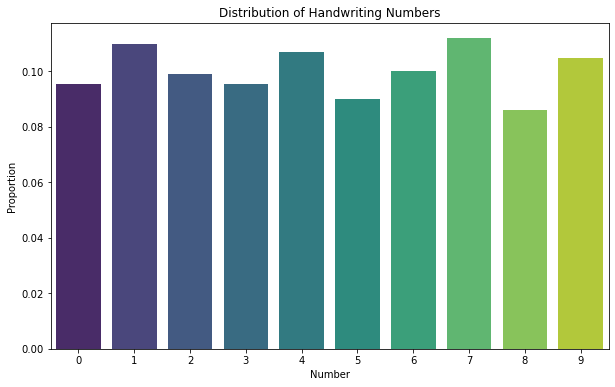

(1600, 784)
(1600,)
Distribution after SMOTE:
 0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: class, dtype: float64


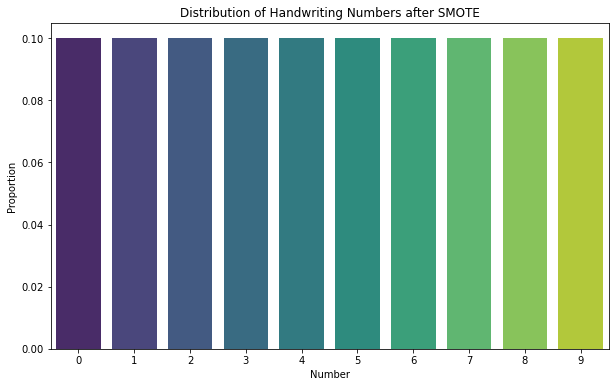

In [3]:
# Check the distribution of the target variable (ratings)
number_counts = y.value_counts(normalize=True) # Get the percentage of each rating
print(number_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=number_counts.index, y=number_counts.values, palette="viridis")
plt.xlabel('Number')
plt.ylabel('Proportion')
plt.title('Distribution of Handwriting Numbers')
plt.show()

# Apply SMOTE to the SVD-transformed training data
smote = SMOTE(random_state=42,k_neighbors=2)

print(X_train.shape)
print(y_train.shape)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Display the new distribution of the target variable after SMOTE
balanced_counts = pd.Series(y_train).value_counts(normalize=True)
print("Distribution after SMOTE:\n", balanced_counts)

# Plot the new distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette="viridis")
plt.xlabel('Number')
plt.ylabel('Proportion')
plt.title('Distribution of Handwriting Numbers after SMOTE')
plt.show()


## 1.3 Model Exploration

### Setting up the Experiment in MLflow

In this section, we define a unique name for our experiment, `"Assignment 10 F1 Precision"`, to help us organize and track our results in **MLflow**. By setting this experiment, we create a dedicated space in MLflow where all metrics, parameters, and model artifacts associated with this experiment will be stored. If an experiment with this name does not already exist, MLflow will automatically create one. This setup allows us to easily monitor and compare different model runs and ensures that all logged data is grouped under this specific experiment for streamlined analysis.


In [4]:
experiment_name = "Assignment 10 F1 Precision"

# Set the experiment
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1730602010855, experiment_id='3', last_update_time=1730602010855, lifecycle_stage='active', name='Assignment 10 F1 Precision', tags={}>

#### 1.3.0 Function for logging metrics

For each dataset, we compute precision, recall, and F1 score using a weighted average to handle class imbalances. These metrics give insight into the model's ability to correctly identify positive cases (precision), its sensitivity (recall), and an overall performance measure (F1 score). After calculating these metrics, we log them to MLflow, rounding each to two decimal places for clarity. Additionally, if training time is provided, we log it as well, giving us a measure of how long model training took. This information will be useful for tracking model performance and comparing different runs in MLflow.

In [5]:
def log_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test, elapsed_time=None):
    # Calculate train metrics
    precision_weighted_train = precision_score(y_true_train, y_pred_train, average='weighted')
    recall_weighted_train = recall_score(y_true_train, y_pred_train, average='weighted')
    f1_weighted_train = f1_score(y_true_train, y_pred_train, average='weighted')
    
    # Calculate test metrics
    precision_weighted_test = precision_score(y_true_test, y_pred_test, average='weighted')
    recall_weighted_test = recall_score(y_true_test, y_pred_test, average='weighted')
    f1_weighted_test = f1_score(y_true_test, y_pred_test, average='weighted')
    
    mlflow.log_metric("train_precision", round(precision_weighted_train, 2))
    mlflow.log_metric("train_recall", round(recall_weighted_train, 2))
    mlflow.log_metric("train_f1", round(f1_weighted_train, 2))
    mlflow.log_metric("test_precision", round(precision_weighted_test, 2))
    mlflow.log_metric("test_recall", round(recall_weighted_test, 2))
    mlflow.log_metric("test_f1", round(f1_weighted_test, 2))
    
    # Log training time if available, with two decimal places
    if elapsed_time is not None:
        mlflow.log_metric("Time_train", round(elapsed_time, 2))


#### 1.3.0 Function for plotting confusion matrix

In [6]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    
    # Save the plot
    plt_path = "confusion_matrix.png"
    plt.savefig(plt_path)
    
    # Log plot as an MLflow artifact
    mlflow.log_artifact(plt_path)
    plt.close()  # Close the plot to avoid displaying it inline


#### 1.3.0 Function for plotting ROC AUC Curvve

In [7]:
def plot_roc_curve(y_true, y_proba, model_name="Model"):
    # Binarize the true labels for multi-class ROC calculation
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_binarized.shape[1]

    # Initialize dictionaries to hold FPR, TPR, and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plotting each class's ROC curve
        plt.plot(fpr[i], tpr[i], linestyle='--', 
                 label=f'Class {i} vs Rest (AUC = {roc_auc[i]:0.2f})')

    # Plotting the diagonal line
    plt.plot([0, 1], [0, 1], 'b--', label='Random Guess')

    # Aesthetics
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.title(f'Multiclass ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    # Save the plot
    plt_path = "ROC_AUC_curve.png"
    plt.savefig(plt_path)
    mlflow.log_artifact(plt_path)
    plt.close()
    
    # Calculate and log average AUC
    average_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Average ROC AUC score: {average_roc_auc:.2f}')
    mlflow.log_metric("Average ROC AUC", round(average_roc_auc, 2))
    
    # Optional: Log individual class AUC scores to MLflow
    for i in range(n_classes):
        mlflow.log_metric(f"ROC AUC Class {i}", round(roc_auc[i], 2))


#### 1.3.0 Function for plotting PR Curvve

In [8]:
def plot_pr_curve(y_true, y_proba, model_name="Model"):
    # Binarize the true labels for multi-class PR calculation
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_binarized.shape[1]

    # Initialize dictionaries to hold Precision, Recall, and AUC for each class
    precision = {}
    recall = {}
    pr_auc = {}

    # Compute Precision-Recall curve and AUC for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        
        # Plotting each class's PR curve
        plt.plot(recall[i], precision[i], linestyle='--', 
                 label=f'Class {i} (AUC = {pr_auc[i]:0.2f})')

    # Aesthetics
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.title(f'Multiclass Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    
    # Save the plot
    plt_path = "PR_curve.png"
    plt.savefig(plt_path)
    mlflow.log_artifact(plt_path)
    plt.close()
    
    # Calculate and log average AUC
    average_pr_auc = np.mean(list(pr_auc.values()))
    print(f'Average PR AUC score: {average_pr_auc:.2f}')
    mlflow.log_metric("Average PR AUC", round(average_pr_auc, 2))
    
    # Optional: Log individual class AUC scores to MLflow
    for i in range(n_classes):
        mlflow.log_metric(f"PR AUC Class {i}", round(pr_auc[i], 2))

#### 1.3.0 Function for plotting gains and lift charts

In [9]:
def plot_gains_and_lift_charts(y_true, y_proba, model_name="Model"):
    # Binarize the true labels for multi-class gains and lift charts calculation
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_binarized.shape[1]
    
    # Create a directory to store charts
    os.makedirs("charts", exist_ok=True)

    for class_index in range(n_classes):
        probas = y_proba[:, class_index]
        true_labels = y_true_binarized[:, class_index]
    
        # Create a DataFrame for easier manipulation
        results = pd.DataFrame({'probability': probas, 'true_label': true_labels})
        results = results.sort_values(by='probability', ascending=False).reset_index(drop=True)
    
        # Calculate cumulative gain
        total_positive = results['true_label'].sum()
        results['cumulative_positive'] = results['true_label'].cumsum()
        results['gain'] = results['cumulative_positive'] / total_positive
    
        # Calculate lift based on deciles
        results['decile'] = pd.qcut(results.index, 10, labels=False)
        lift = results.groupby('decile')['true_label'].sum() / (total_positive / 10)
    
        # Plot Gain Chart
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(results) + 1) / len(results), results['gain'], label='Cumulative Gain', color='blue')
        plt.plot([0, 1], [0, 1], label='Random Guess', linestyle='--', color='red')
        plt.title(f'Cumulative Gain Chart for Class {class_index} - {model_name}')
        plt.xlabel('Percentage of Total Population')
        plt.ylabel('Cumulative Gain')
        plt.legend()
        plt.grid(True)
    
        # Save Gain Chart
        gain_chart_filename = f'charts/cumulative_gain_class_{class_index}.png'
        plt.savefig(gain_chart_filename)
        plt.close()

        # Plot Lift Chart
        plt.figure(figsize=(10, 6))
        plt.plot(lift.index + 1, lift, marker='o', label='Lift', color='green')  # Deciles on x-axis, indexed from 1 to 10
        plt.title(f'Lift Chart for Class {class_index} - {model_name}')
        plt.xlabel('Decile')
        plt.ylabel('Lift')
        plt.xticks(np.arange(1, 11), labels=np.arange(1, 11))  # Label deciles from 1 to 10
        plt.legend()
        plt.grid(True)
    
        # Save Lift Chart
        lift_chart_filename = f'charts/lift_chart_class_{class_index}.png'
        plt.savefig(lift_chart_filename)
        plt.close()
    
        # Log the artifacts to MLflow
        mlflow.log_artifact(gain_chart_filename, artifact_path='charts')
        mlflow.log_artifact(lift_chart_filename, artifact_path='charts')

    # Optional: Show a message or log that the charts were saved and logged
    print("Gains and Lift charts saved and logged to MLflow successfully.")

## Training The Models

### 1.3.1 Gradient Boost : Scoring For Precision

Gradient boosting models are powerful ensemble techniques that build predictive models in a sequential manner by combining the predictions of several weaker models, typically decision trees. Each subsequent model focuses on correcting the errors made by the previous ones, leading to improved accuracy and robustness. In our case, using gradient boosting will help enhance the precision of our digit classification task on the MNIST dataset, as these models are adept at handling complex patterns and can effectively manage class imbalances, which is crucial for achieving higher precision in predictions.

In [ ]:
print(mlflow.get_tracking_uri())

In [10]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'grad__n_estimators': [10, 30, 40],
    'grad__learning_rate': [0.05, 0.1, 0.3],
    'grad__criterion': ['friedman_mse', 'squared_error'],
    'grad__subsample': [0.2, 0.4, 0.6]
}

# Start a new run
with mlflow.start_run(run_name="Gradient_Boost_Manual_Precision") as run:
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('grad', GradientBoostingClassifier(random_state=42))])
        
    # Initialize GridSearchCV with multiclass-compatible precision scoring
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='precision_weighted')

    # Fit the grid search to the training data
    start_time = time.time()
    score = None  # Initialize score for this iteration

    grid_search.fit(X_train, y_train) 
    score = grid_search.score(X_test, y_test)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Optional: print runtime for each architecture
    elapsed_time = time.time() - start_time

    input_example = pd.DataFrame(X_train)
    input_example = input_example.iloc[:1]
    mlflow.sklearn.log_model(best_model, "model", input_example=input_example)
    
    # Log parameters and score for the best model
    mlflow.log_params(best_params)
    mlflow.log_metric("score", score)
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    log_metrics(y_train, y_pred_train, y_test, y_pred_test, elapsed_time)
    
    plot_confusion_matrix(y_test, y_pred_test, model_name="Gradient Boost on MNIST")
    mlp_proba = best_model.predict_proba(X_test)
    plot_roc_curve(y_test, mlp_proba, model_name="Gradient Boost on MNIST")
    plot_pr_curve(y_test, mlp_proba, model_name="Gradient Boost on MNIST")
    plot_gains_and_lift_charts(y_test, mlp_proba, model_name="Gradient Boost on MNIST")
    
    manual_run_id = run.info.run_id

# You can print or save the run_id for later use
print(f"Manual Run ID: {manual_run_id}")

# Initialize MLflow client
client = MlflowClient()

# The run_id was captured earlier during the run
# Specify the model URI
model_uri = f"runs:/{manual_run_id}/model"

# Define the model name
model_name = "Gradient_Boost_Precision"

# Register the model
result = mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Name: {result.name}\nVersion: {result.version}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


2024/11/03 14:57:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\princ\AppData\Local\Temp\tmpzc6sazep\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 14:57:53 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel1",
      "pixel2",
      "pixel3",
      "pixel4",
      "pixel5",
      "pixel6",
      "pixel7",
      "pixel8",
      "pixel9",
      "pixel10",
      "pixel11",
      "pixel12",
      "pixel13",
      "pixel14",
      "pixel15",
      "pixel16",
      "pixel17",
      "pixel18",
      "pixel19",
      "pixel20",
      "pixel21",
      "pixel22",
      "pixel23",
      "pixel24",
      "pixel25",
      "pixel26",
      "pixel27",
      "pixel28",
      "pixel29",
      "pixel30",
      "pixel31",
      "pixel32",

Average ROC AUC score: 0.98
Average PR AUC score: 0.93
Gains and Lift charts saved and logged to MLflow successfully.


2024/11/03 14:58:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient_Boost_Manual_Precision at: http://131.247.92.12:5011/#/experiments/3/runs/5b4641df773148e398c5d818440ccd6b.
2024/11/03 14:58:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5011/#/experiments/3.


Manual Run ID: 5b4641df773148e398c5d818440ccd6b


Registered model 'Gradient_Boost_Precision' already exists. Creating a new version of this model...
2024/11/03 14:58:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient_Boost_Precision, version 3


Name: Gradient_Boost_Precision
Version: 3


Created version '3' of model 'Gradient_Boost_Precision'.


### 1.3.2 Random Forest : Scoring For Precision

Random Forest is an ensemble learning method that constructs multiple decision trees during training and merges their predictions to improve accuracy and control overfitting. By averaging the results of many trees, Random Forest can effectively handle high-dimensional data and reduce variance, leading to more reliable predictions. In our context of classifying digits from the MNIST dataset, employing Random Forest can enhance model performance, particularly in terms of stability and precision, as it is less sensitive to noise and can better generalize across unseen data.

In [11]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'rf__n_estimators': [50, 100, 120],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': range(3, 14, 2),
    'rf__min_samples_split': range(4, 11, 2),
    'rf__min_samples_leaf': [3, 4, 5]           # Minimum number of samples required to be at a leaf node
}


# Start a new run
with mlflow.start_run(run_name="Random_Forest_Manual_Precision") as run:
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=42))])
        
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='precision_weighted')

    # Fit the grid search to the training data
    start_time = time.time()
    score = None  # Initialize score for this iteration

    grid_search.fit(X_train, y_train) 
    score = grid_search.score(X_test, y_test)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

   
    # Optional: print runtime for each architecture
    elapsed_time = time.time() - start_time


    input_example = pd.DataFrame(X_train)
    input_example = input_example.iloc[:1]
    mlflow.sklearn.log_model(best_model, "model", input_example=input_example)
    
    # Log parameters and score for the best model
    mlflow.log_params(best_params)
    mlflow.log_metric("score", score)
    
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    log_metrics(y_train, y_pred_train, y_test, y_pred_test, elapsed_time)
    

    plot_confusion_matrix(y_test, y_pred_test, model_name="Random Forest on MNIST")
    mlp_proba = best_model.predict_proba(X_test)
    plot_roc_curve(y_test, mlp_proba, model_name="Random Forest on MNIST")
    plot_pr_curve(y_test, mlp_proba, model_name="Random Forest on MNIST")
    plot_gains_and_lift_charts(y_test, mlp_proba, model_name="Random Forest on MNIST")
    
    manual_run_id = run.info.run_id

# You can print or save the run_id for later use
print(f"Manual Run ID: {manual_run_id}")


# Initialize MLflow client
client = MlflowClient()

# The run_id was captured earlier during the run
# Specify the model URI
model_uri = f"runs:/{manual_run_id}/model"

# Define the model name
model_name = "Random_Forest_Precision"

# Register the model
result = mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Name: {result.name}\nVersion: {result.version}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


2024/11/03 15:04:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\princ\AppData\Local\Temp\tmpn_culqyo\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 15:04:09 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel1",
      "pixel2",
      "pixel3",
      "pixel4",
      "pixel5",
      "pixel6",
      "pixel7",
      "pixel8",
      "pixel9",
      "pixel10",
      "pixel11",
      "pixel12",
      "pixel13",
      "pixel14",
      "pixel15",
      "pixel16",
      "pixel17",
      "pixel18",
      "pixel19",
      "pixel20",
      "pixel21",
      "pixel22",
      "pixel23",
      "pixel24",
      "pixel25",
      "pixel26",
      "pixel27",
      "pixel28",
      "pixel29",
      "pixel30",
      "pixel31",
      "pixel32",

Average ROC AUC score: 0.99
Average PR AUC score: 0.96
Gains and Lift charts saved and logged to MLflow successfully.


2024/11/03 15:04:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest_Manual_Precision at: http://131.247.92.12:5011/#/experiments/3/runs/a543ac51507c456ea9391cd58fc410dc.
2024/11/03 15:04:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5011/#/experiments/3.


Manual Run ID: a543ac51507c456ea9391cd58fc410dc


Registered model 'Random_Forest_Precision' already exists. Creating a new version of this model...
2024/11/03 15:04:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random_Forest_Precision, version 2


Name: Random_Forest_Precision
Version: 2


Created version '2' of model 'Random_Forest_Precision'.


### 1.3.3 SVC : Scoring For Precision

Support Vector Classifier (SVC) is a supervised machine learning algorithm that identifies the optimal hyperplane to separate different classes in the feature space. It is particularly effective for high-dimensional data and can handle non-linear relationships through the use of kernel functions. In the context of our MNIST digit classification task, SVC can help achieve high precision by effectively distinguishing between the different digit classes, especially when the dataset is complex or when there are overlaps between classes, making it a strong candidate for achieving accurate predictions in our model ensemble.

In [14]:

param_grid = {
    'svc__C': [0.1, 1, 10],  # Example parameters for SVC
    'svc__kernel': ['linear', 'rbf'],  # Example kernel types
    'svc__gamma': ['scale', 'auto'],  # For RBF kernel
    # Add other parameters as needed
}

# Start a new run
with mlflow.start_run(run_name="SVC_Manual_Precision") as run:
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(probability=True, random_state=42))])  # Set probability=True
        
        
        
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='precision_weighted')

    # Fit the grid search to the training data
    start_time = time.time()
    score = None  # Initialize score for this iteration

    grid_search.fit(X_train, y_train) 
    score = grid_search.score(X_test, y_test)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Optional: print runtime for each architecture
    elapsed_time = time.time() - start_time

    input_example = pd.DataFrame(X_train)
    input_example = input_example.iloc[:1]
    mlflow.sklearn.log_model(best_model, "model", input_example=input_example)
    
    # Log parameters and score for the best model
    mlflow.log_params(best_params)
    mlflow.log_metric("score", score)
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    log_metrics(y_train, y_pred_train, y_test, y_pred_test, elapsed_time)
    
    plot_confusion_matrix(y_test, y_pred_test, model_name="SVC on MNIST")
    mlp_proba = best_model.predict_proba(X_test)
    plot_roc_curve(y_test, mlp_proba, model_name="SVC on MNIST")
    plot_pr_curve(y_test, mlp_proba, model_name="SVC on MNIST")
    plot_gains_and_lift_charts(y_test, mlp_proba, model_name="SVC on MNIST")
    
    manual_run_id = run.info.run_id

# You can print or save the run_id for later use
print(f"Manual Run ID: {manual_run_id}")

# Initialize MLflow client
client = MlflowClient()

# The run_id was captured earlier during the run
# Specify the model URI
model_uri = f"runs:/{manual_run_id}/model"

# Define the model name
model_name = "SVC_Precision"

# Register the model
result = mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Name: {result.name}\nVersion: {result.version}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2024/11/03 15:08:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\princ\AppData\Local\Temp\tmpjqwdyuy9\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 15:08:44 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel1",
      "pixel2",
      "pixel3",
      "pixel4",
      "pixel5",
      "pixel6",
      "pixel7",
      "pixel8",
      "pixel9",
      "pixel10",
      "pixel11",
      "pixel12",
      "pixel13",
      "pixel14",
      "pixel15",
      "pixel16",
      "pixel17",
      "pixel18",
      "pixel19",
      "pixel20",
      "pixel21",
      "pixel22",
      "pixel23",
      "pixel24",
      "pixel25",
      "pixel26",
      "pixel27",
      "pixel28",
      "pixel29",
      "pixel30",
      "pixel31",
      "pixel32",

Average ROC AUC score: 0.99
Average PR AUC score: 0.94
Gains and Lift charts saved and logged to MLflow successfully.


2024/11/03 15:09:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_Manual_Precision at: http://131.247.92.12:5011/#/experiments/3/runs/9f4d6c48619d457cb62abcf034fd98c0.
2024/11/03 15:09:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5011/#/experiments/3.


Manual Run ID: 9f4d6c48619d457cb62abcf034fd98c0


Registered model 'SVC_Precision' already exists. Creating a new version of this model...
2024/11/03 15:09:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC_Precision, version 2


Name: SVC_Precision
Version: 2


Created version '2' of model 'SVC_Precision'.


### 1.3.4 AdaBoost 

AdaBoost, short for Adaptive Boosting, is an ensemble learning technique that combines multiple weak classifiers to create a strong classifier. It works by adjusting the weights of incorrectly classified instances, thereby focusing subsequent classifiers on the harder-to-predict cases. This iterative approach helps improve accuracy and reduces bias. In our MNIST digit classification task, using AdaBoost can enhance precision by effectively leveraging the strengths of simpler models, allowing us to build a robust classifier that performs well even in the presence of noisy data or class imbalances.

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'Ada__n_estimators': [50],                    # Fewer values to test
    'Ada__learning_rate': [0.1, 1]
}

# Start a new run
with mlflow.start_run(run_name="AdaBoost_Manual_Precision") as run:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('Ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=42))])
        
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='precision_weighted')

    # Fit the grid search to the training data
    start_time = time.time()
    score = None  # Initialize score for this iteration

    grid_search.fit(X_train, y_train) 
    score = grid_search.score(X_test, y_test)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Optional: print runtime for each architecture
    elapsed_time = time.time() - start_time

    input_example = pd.DataFrame(X_train)
    input_example = input_example.iloc[:1]
    mlflow.sklearn.log_model(best_model, "model", input_example=input_example)
    
    # Log parameters and score for the best model
    mlflow.log_params(best_params)
    mlflow.log_metric("score", score)
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    log_metrics(y_train, y_pred_train, y_test, y_pred_test, elapsed_time)
    
    plot_confusion_matrix(y_test, y_pred_test, model_name="AdaBoost on MNIST")
    mlp_proba = best_model.predict_proba(X_test)
    plot_roc_curve(y_test, mlp_proba, model_name="AdaBoost on MNIST")
    plot_pr_curve(y_test, mlp_proba, model_name="AdaBoost on MNIST")
    plot_gains_and_lift_charts(y_test, mlp_proba, model_name="AdaBoost on MNIST")
    
    manual_run_id = run.info.run_id

# You can print or save the run_id for later use
print(f"Manual Run ID: {manual_run_id}")

# Initialize MLflow client
client = MlflowClient()

# The run_id was captured earlier during the run
# Specify the model URI
model_uri = f"runs:/{manual_run_id}/model"

# Define the model name
model_name = "AdaBoost_Precision"

# Register the model
result = mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Name: {result.name}\nVersion: {result.version}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits


2024/11/03 15:10:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\princ\AppData\Local\Temp\tmp2cbfzj4u\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 15:10:25 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel1",
      "pixel2",
      "pixel3",
      "pixel4",
      "pixel5",
      "pixel6",
      "pixel7",
      "pixel8",
      "pixel9",
      "pixel10",
      "pixel11",
      "pixel12",
      "pixel13",
      "pixel14",
      "pixel15",
      "pixel16",
      "pixel17",
      "pixel18",
      "pixel19",
      "pixel20",
      "pixel21",
      "pixel22",
      "pixel23",
      "pixel24",
      "pixel25",
      "pixel26",
      "pixel27",
      "pixel28",
      "pixel29",
      "pixel30",
      "pixel31",
      "pixel32",

Average ROC AUC score: 0.92
Average PR AUC score: 0.65
Gains and Lift charts saved and logged to MLflow successfully.


2024/11/03 15:10:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run AdaBoost_Manual_Precision at: http://131.247.92.12:5011/#/experiments/3/runs/6bef5d97127b46c78a228aee08bed7f8.
2024/11/03 15:10:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5011/#/experiments/3.


Manual Run ID: 6bef5d97127b46c78a228aee08bed7f8


Registered model 'AdaBoost_Precision' already exists. Creating a new version of this model...
2024/11/03 15:10:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AdaBoost_Precision, version 3


Name: AdaBoost_Precision
Version: 3


Created version '3' of model 'AdaBoost_Precision'.


### 1.3.5 Multilayer Perceptron

A Multilayer Perceptron (MLP) is a type of artificial neural network composed of multiple layers of neurons, including an input layer, one or more hidden layers, and an output layer. Each neuron in the MLP uses activation functions to introduce non-linearities, enabling the network to learn complex patterns in the data. In the context of our MNIST digit classification task, MLPs can effectively capture intricate relationships between the pixel values of the images and the corresponding digit labels, making them well-suited for high-dimensional datasets like MNIST. This capacity for learning complex representations can significantly improve precision in predicting the correct digits.



In [17]:
# Define different architectures
architectures = [
    (10, 5),               # Two hidden layers with 10 and 5 neurons
    (20, 10, 5),           # Three hidden layers with 20, 10, and 5 neurons
    (100, 50, 25, 10)   # Five hidden layers for increased depth
]

# Define the parameter grid
param_grid = {
    'mlp__activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],  # Solvers
    'mlp__max_iter': [5, 15, 20]  # Number of iterations for training
}



with mlflow.start_run(run_name="MLP_Manual_Precision") as run:
    # Initialize variables
    best_score = -np.inf
    best_mlp_model = None
    best_hidden_layers = None
    best_params = None

    # Iterate over architectures
    for hidden_layers in architectures:
        # Create a pipeline with a scaler and the MLPClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPClassifier(hidden_layer_sizes=hidden_layers, random_state=42))
        ])
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='precision_weighted')
    
        # Fit the grid search to the training data
        start_time = time.time()
        score = None  # Initialize score for this iteration
        try:
            grid_search.fit(X_train, y_train) 
            score = grid_search.score(X_test, y_test)
            
            # Check if this is the best score
            if score > best_score:
                best_score = score
                best_mlp_model = grid_search.best_estimator_
                best_hidden_layers = hidden_layers
                best_params = grid_search.best_params_
    
        except Exception as e:
            print(f"An error occurred while fitting the model with architecture {hidden_layers}: {e}")
        
        # Optional: print runtime for each architecture
        elapsed_time = time.time() - start_time
        if score is not None:
            print(f"Architecture: {hidden_layers}, Score: {score:.4f}, Time: {elapsed_time:.2f}s")
        else:
            print(f"Architecture: {hidden_layers}, fitting failed, Time: {elapsed_time:.2f}s")

    # After the loop, log the best model and parameters if found
    if best_mlp_model is not None:
        input_example = pd.DataFrame(X_train)
        input_example = input_example.iloc[:1]
        
        mlflow.sklearn.log_model(best_mlp_model, "model", input_example=input_example)
        
        # Log parameters and score for the best model
        mlflow.log_params(best_params)
        mlflow.log_metric("score", best_score)
        mlflow.log_param("hidden_layers", best_hidden_layers)

    
    y_pred_train = best_mlp_model.predict(X_train)
    y_pred_test = best_mlp_model.predict(X_test)
    log_metrics(y_train, y_pred_train, y_test, y_pred_test, elapsed_time)
    

    plot_confusion_matrix(y_test, y_pred_test, model_name="Neural Network on MNIST")
    mlp_proba = best_mlp_model.predict_proba(X_test)
    plot_roc_curve(y_test, mlp_proba, model_name="Neural Network on MNIST")
    plot_gains_and_lift_charts(y_test, mlp_proba, model_name="Neural Network on MNIST")
    

    # Get the run ID
    manual_run_id = run.info.run_id

# You can print or save the run_id for later use
print(f"Manual Run ID: {manual_run_id}")


# Initialize MLflow client
client = MlflowClient()

# The run_id was captured earlier during the run
# Specify the model URI
model_uri = f"runs:/{manual_run_id}/model"

# Define the model name
model_name = "MLP_Precision"

# Register the model
result = mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Name: {result.name}\nVersion: {result.version}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Architecture: (10, 5), Score: 0.8029, Time: 10.70s
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Architecture: (20, 10, 5), Score: 0.7919, Time: 12.95s
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Architecture: (100, 50, 25, 10), Score: 0.8638, Time: 28.51s


2024/11/03 15:11:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\princ\AppData\Local\Temp\tmp9ossb9vf\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/03 15:12:00 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "pixel1",
      "pixel2",
      "pixel3",
      "pixel4",
      "pixel5",
      "pixel6",
      "pixel7",
      "pixel8",
      "pixel9",
      "pixel10",
      "pixel11",
      "pixel12",
      "pixel13",
      "pixel14",
      "pixel15",
      "pixel16",
      "pixel17",
      "pixel18",
      "pixel19",
      "pixel20",
      "pixel21",
      "pixel22",
      "pixel23",
      "pixel24",
      "pixel25",
      "pixel26",
      "pixel27",
      "pixel28",
      "pixel29",
      "pixel30",
      "pixel31",
      "pixel32",

Average ROC AUC score: 0.98
Gains and Lift charts saved and logged to MLflow successfully.


2024/11/03 15:12:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run MLP_Manual_Precision at: http://131.247.92.12:5011/#/experiments/3/runs/ae4f0b5e683e4590804117de7aca96cc.
2024/11/03 15:12:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://131.247.92.12:5011/#/experiments/3.


Manual Run ID: ae4f0b5e683e4590804117de7aca96cc


Registered model 'MLP_Precision' already exists. Creating a new version of this model...
2024/11/03 15:12:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MLP_Precision, version 3


Name: MLP_Precision
Version: 3


Created version '3' of model 'MLP_Precision'.


# Further Steps

Next, we will select the best-performing model based on evaluation metrics and the business case. Following this, we will deploy the model as a RESTful API using MLFlow, ensuring that it is accessible for prediction requests and capable of responding with probability scores for each digit class. We will also document the API endpoints, parameters, and expected response formats, providing sample requests and responses for testing purposes.